In this notebook we will test whether Croissant recovers the sky temperature for some simple analytic beams with no horizon.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.units import s as seconds
from lunarsky import Time
from pygdsm import GlobalSkyModel16

import croissant as cro

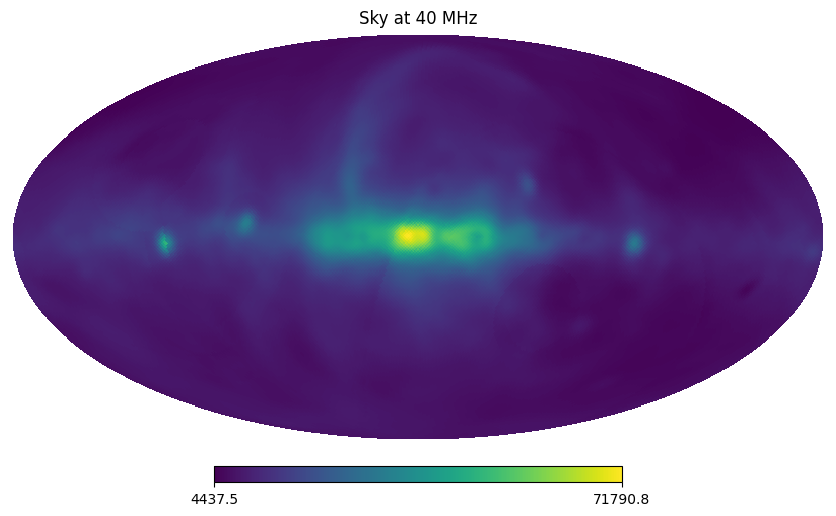

In [2]:
gsm = GlobalSkyModel16(
    freq_unit="MHz", data_unit="TRJ", resolution="lo", include_cmb=True
)
freq = np.linspace(40, 80, 41)
sky_map = gsm.generate(freq)
lmax = 32
nside = 64
sky = cro.Sky(sky_map, freq)
hp.mollview(sky.data[0], title=f"Sky at {freq[0]:.0f} MHz")

## Uniform beam

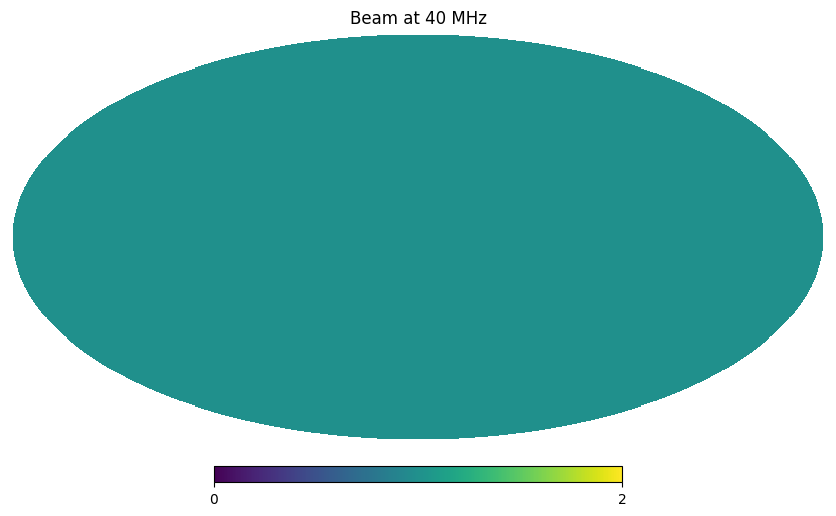

In [3]:
beam_data = np.ones_like(sky_map)
beam = cro.Beam(
    beam_data,
    freqs=freq,
    sampling="healpix",
    horizon=np.ones(beam_data.shape[1:], dtype=bool),
)

hp.mollview(beam.data[0], title=f"Beam at {freq[0]:.0f} MHz")

In [4]:
# full sidereal day on the earth
lon = 122.27
lat = 37.87
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)
sim = cro.Simulator(beam, sky, times.jd, freq, lon, lat, world="earth", Tgnd=0)

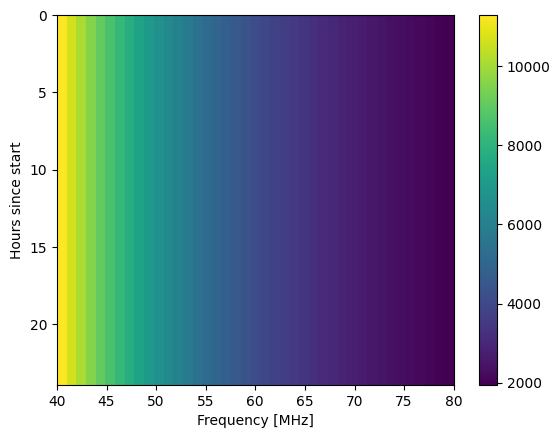

In [5]:
vis = sim.sim()

dt = (t_end.jd - t_start.jd) * 24
plt.figure()
plt.imshow(
    vis, aspect="auto", interpolation="none", extent=[freq[0], freq[-1], dt, 0]
)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Hours since start")
plt.colorbar()
plt.show()

With a uniform beam we should simply recover the mean sky temperature. In the language of spherical harmonics, the mean sky temperature is given by
$$<T_{\rm sky}> = a_{00} Y_0^0,$$ i.e. the (0,0)-mode of the spherical harmonics decomposition.

In [6]:
# there's no time dependence for the uniform beam
np.allclose(vis, vis[0], rtol=1e-4)

True

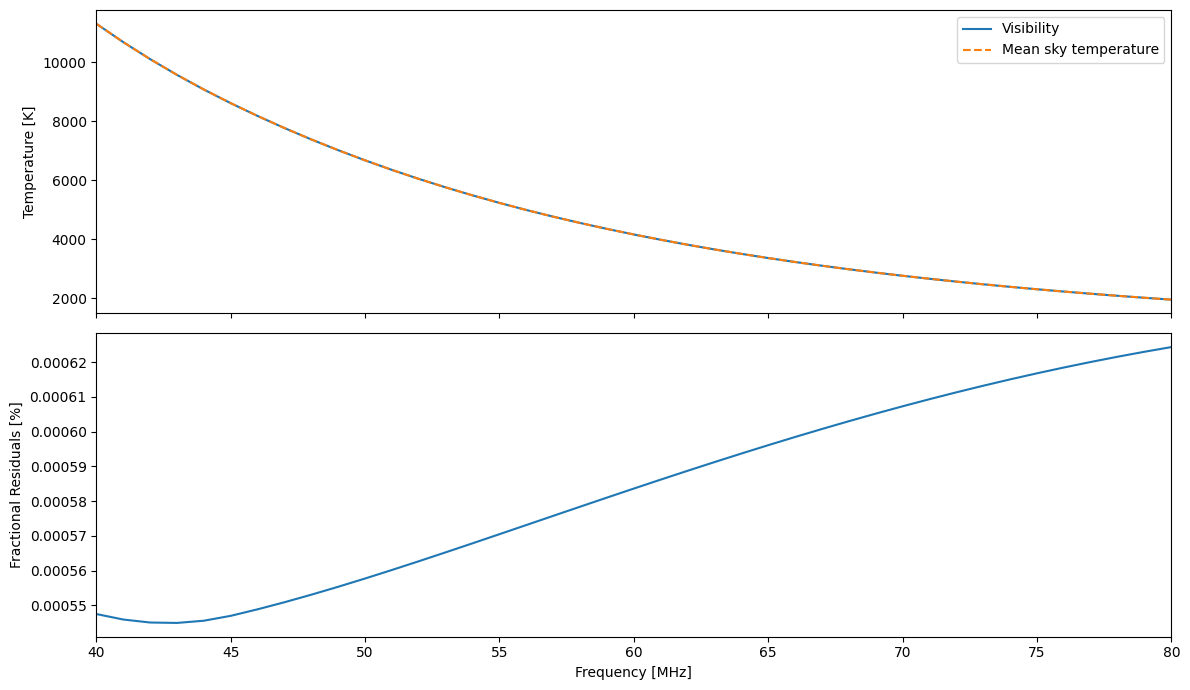

In [7]:
mean_sky = (
    sim.sky.compute_alm_eq(world=sim.world)[:, 0, sim.lmax].real
    * cro.constants.Y00
)  # a00 Y00

fig, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True)
axs[0].plot(sim.freqs, vis[0], label="Visibility")
axs[0].plot(sky.freqs, mean_sky, ls="--", label="Mean sky temperature")
axs[0].set_ylabel("Temperature [K]")
axs[0].legend()
axs[1].plot(sim.freqs, (vis[0] - mean_sky) / vis[0] * 100)
axs[1].set_ylabel("Fractional Residuals [%]")
axs[1].set_xlabel("Frequency [MHz]")
plt.setp(axs, xlim=(sim.freqs.min(), sim.freqs.max()))
plt.tight_layout()
plt.show()

In [8]:
# we get the same result on the moon
t_end_moon = t_start + cro.constants.sidereal_day_moon * seconds
sim_moon = cro.Simulator(
    beam, sky, times.jd, freq, lon, lat, world="moon", Tgnd=0
)
vis_moon = sim_moon.sim()

In [9]:
np.allclose(vis, vis_moon, rtol=1e-4)

True

## Dipole beam

In [10]:
phi = cro.utils.generate_phi(sampling="healpix", nside=nside)
theta = cro.utils.generate_theta(sampling="healpix", nside=nside)

y10 = 1 / 2 * np.sqrt(3 / np.pi) * np.cos(theta)

beam_data = 30 * cro.constants.Y00 + 10 * y10
beam_data = (freq[:, None] / freq[0]) ** 2 * beam_data[None, :]

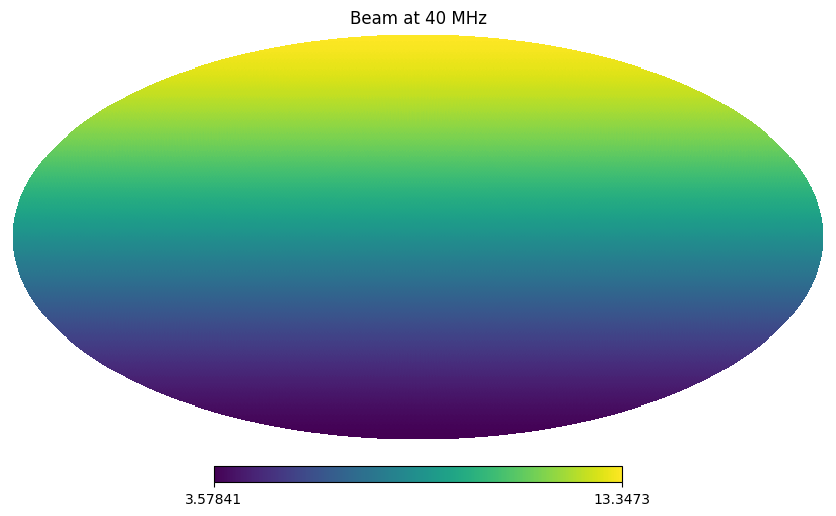

In [11]:
beam = cro.Beam(
    beam_data,
    freqs=freq,
    sampling="healpix",
    horizon=np.ones(beam_data.shape[1:], dtype=bool),
)

hp.mollview(beam.data[0], title=f"Beam at {freq[0]:.0f} MHz")

In [12]:
# run the simulation with all the same parameters, but put it on the north pole
# on the north pole the equatorial and topocentric coordinates match
sim = cro.Simulator(beam, sky, times.jd, freq, 0, 90, world="earth", Tgnd=0)

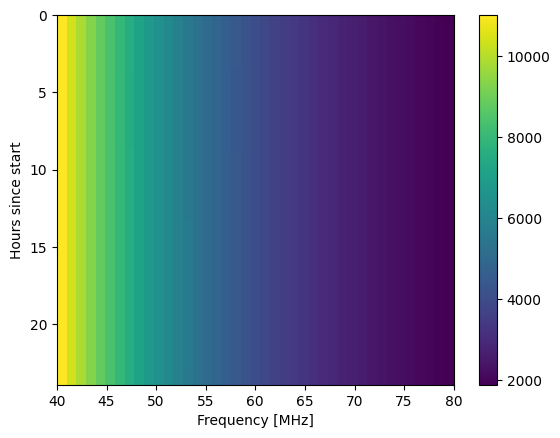

In [14]:
vis = sim.sim()

plt.figure()
plt.imshow(
    vis, aspect="auto", interpolation="none", extent=[freq[0], freq[-1], dt, 0]
)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Hours since start")
plt.colorbar()
plt.show()

A dipole beam should pick out the (0, 0) and (1, 0) modes of the sky. These are symmetric about the rotation axis of earth, hence there should be no time dependence.

In [16]:
# no change with time
np.allclose(vis, vis[0], rtol=1e-3)

True

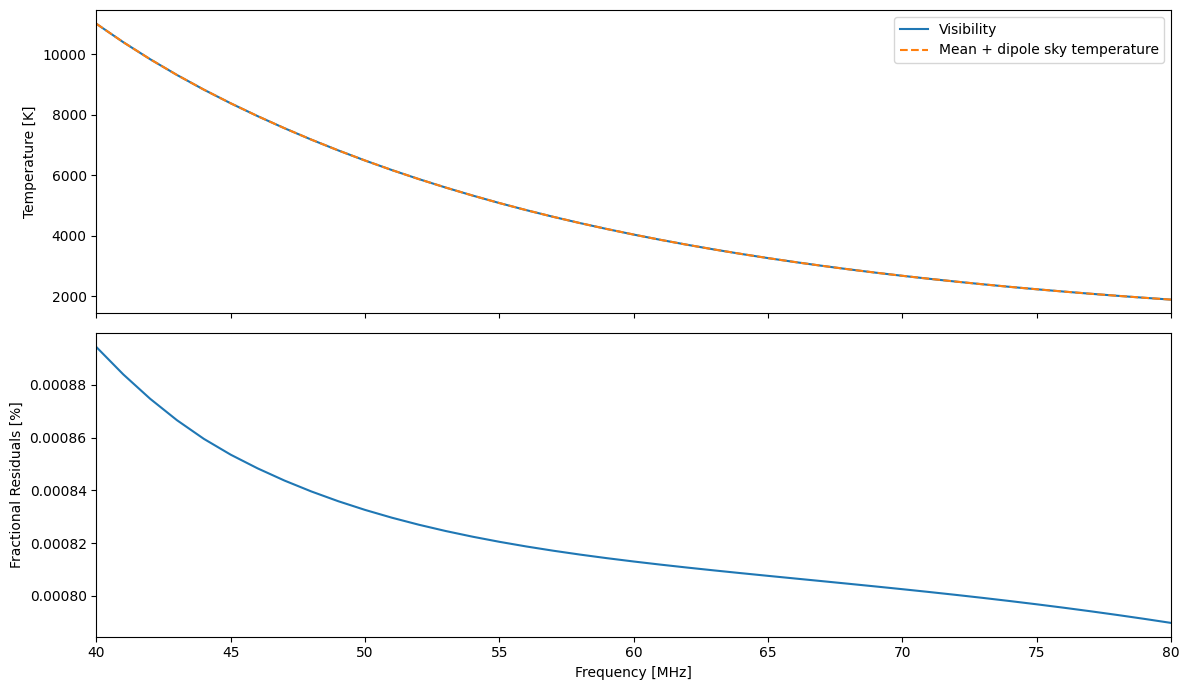

In [24]:
# the visibility is the mean sky + dipole contribution
sky_alm_eq = sim.sky.compute_alm_eq(world=sim.world)
beam_alm_eq = sim.compute_beam_eq()

dipole_sky = sky_alm_eq[:, 1, sim.lmax] * beam_alm_eq[:, 1, sim.lmax]

dipole_sky /= sim.beam.compute_norm()  # normalized by beam power

fig, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True)
axs[0].plot(sim.freqs, vis[0], label="Visibility")
axs[0].plot(
    sky.freqs,
    mean_sky + dipole_sky,
    ls="--",
    label="Mean + dipole sky temperature",
)
axs[0].set_ylabel("Temperature [K]")
axs[0].legend()
axs[1].plot(
    sim.freqs,
    (vis[0] - (mean_sky + dipole_sky)) / vis[0] * 100,
)
axs[1].set_ylabel("Fractional Residuals [%]")
axs[1].set_xlabel("Frequency [MHz]")
plt.setp(axs, xlim=(sim.freqs.min(), sim.freqs.max()))
plt.tight_layout()
plt.show()

In [25]:
np.allclose(vis[0], mean_sky + dipole_sky)

True